In [ ]:
#pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [8]:
import psycopg2
import pandas as pd
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image, display, HTML
from ipywidgets import Dropdown, Output, VBox, Label, Button
import ipywidgets as widgets
import re
from langdetect import detect, DetectorFactory

from langdetect.lang_detect_exception import LangDetectException
from collections import Counter, defaultdict

import spotipy
from spotipy.oauth2 import SpotifyOAuth

from dotenv import load_dotenv
import os

import warnings
warnings.simplefilter('ignore')

In [12]:
# Charger les variables d'environnement depuis le fichier .env
load_dotenv()

python-dotenv could not parse statement starting at line 18


True

## Connexion aux Données Spotify

In [13]:
# Informations de connexion
host= os.getenv("koyeb_postgres_host")
dbname = os.getenv("koyeb_postgres_db")
user = os.getenv("koyeb_postgres_user")
password = os.getenv("koyeb_postgres_password")

In [14]:
# Connexion à la base de données
conn = psycopg2.connect(host=host, dbname=dbname, user=user, password=password)
cursor = conn.cursor()

# Fonction pour lire une table dans un DataFrame
def lire_table(conn, table_name):
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, conn)
    return df

# Liste des tables à lire
tables = {
    "tracks": "df_tracks",
    "artists": "df_artists",
    "artists_info": "df_artists_info",
    "parole_morceaux": "df_parole_morceaux"
}

# Lire les tables et les stocker dans les bonnes variables
with conn:
    for table_name, var_name in tables.items():
        globals()[var_name] = lire_table(conn, table_name)


## Définition des données :

#### Dictionnaire des données pour `tracks_df` (Les morceaux les plus écoutés)
<p style="font-size:10px;">
- <b>track_name</b> : Le nom du morceau<br>
- <b>artist_name</b> : Le nom de l'artiste<br>
- <b>artist_id</b> : L'ID unique de l'artiste<br>
- <b>track_id</b> : L'ID unique du morceau<br>
- <b>popularity</b> : Popularité du morceau (score entre 0 et 100)<br>
- <b>duration_ms</b> : Durée du morceau en millisecondes<br>
- <b>explicit</b> : Si le morceau est explicite<br>
- <b>album_name</b> : Le nom de l'album<br>
- <b>album_id</b> : L'ID de l'album<br>
- <b>album_release_date</b> : Date de sortie de l'album (format: 'YYYY-MM-DD')<br>
- <b>album_type</b> : Le type d'album (ex: 'album', 'single', 'compilation')<br>
- <b>album_total_tracks</b> : Nombre total de morceaux dans l'album<br>
- <b>album_images</b> : URL de l'image de l'album<br>
- <b>preview_url</b> : URL pour l'aperçu audio du morceau<br>
- <b>external_urls</b> : URL vers le morceau sur Spotify<br>
</p>

#### Dictionnaire des données pour `artists_df` (Les artistes les plus écoutés)
<p style="font-size:10px;">
- <b>artist_name</b> : Le nom de l'artiste<br>
- <b>artist_id</b> : L'ID unique de l'artiste<br>
- <b>popularity</b> : Popularité de l'artiste (score entre 0 et 100)<br>
- <b>genres</b> : Liste des genres de l'artiste<br>
- <b>followers</b> : Nombre de followers de l'artiste<br>
- <b>external_urls</b> : URL vers l'artiste sur Spotify<br>
- <b>image_url</b> : URL de l'image de l'artiste<br>
- <b>type</b> : Type d'entité (ex: 'artist', 'group', etc.)<br>
- <b>uri</b> : URI unique de l'artiste<br>
</p>

#### Dictionnaire des données pour `parole_morceaux` (Les artistes les plus écoutés)
<p style="font-size:10px;">
- <b>track_name</b> : Le nom du morceau<br>
- <b>artist_name</b> : Le nom de l'artiste<br>
- <b>parole</b> : Parole du morceau<br>
</p>


## Exploration des données

### df_artists

In [15]:
print("\nInformations générales :")
df_artists.info()

print("\nStatistiques descriptives (colonnes numériques) :")
print(df_artists.describe())


Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artist_id      50 non-null     object
 1   artist_name    50 non-null     object
 2   popularity     50 non-null     int64 
 3   genres         50 non-null     object
 4   followers      50 non-null     int64 
 5   external_urls  50 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB

Statistiques descriptives (colonnes numériques) :
       popularity     followers
count   50.000000  5.000000e+01
mean    55.560000  2.389977e+06
std     15.210308  6.246822e+06
min     25.000000  4.642000e+03
25%     48.000000  1.662638e+05
50%     54.500000  3.225820e+05
75%     63.750000  1.067288e+06
max     93.000000  3.656278e+07


***Pas de valeurs manquantes, types ok et colonnes numériques cohérentes pour df_artists***

In [16]:
print("\nTop valeurs pour la variable genres :")
print(df_artists['genres'].value_counts().head(3))


Top valeurs pour la variable genres :
genres
[]               28
[jazz rap]        1
[pop urbaine]     1
Name: count, dtype: int64


Pour le genre plus de la moitié des données sont [], on utilisera donc le genre de la table df_artists_info

### df_artists_info

In [17]:
print("\nInformations générales :")
df_artists_info.info()


Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mbid             76 non-null     object
 1   artist_name      76 non-null     object
 2   url              76 non-null     object
 3   listeners        76 non-null     object
 4   playcount        76 non-null     object
 5   similar_artists  76 non-null     object
 6   tags             76 non-null     object
 7   bio_summary      76 non-null     object
dtypes: object(8)
memory usage: 4.9+ KB


***Pas de valeurs manquantes, mais erreur sur les types pour listeners et playcount***

In [18]:
# Convertir les colonnes 'listeners' et 'playcount' en type numérique
df_artists_info['listeners'] = pd.to_numeric(df_artists_info['listeners'], errors='coerce')
df_artists_info['playcount'] = pd.to_numeric(df_artists_info['playcount'], errors='coerce')

In [19]:
print("\nStatistiques descriptives (colonnes numériques) :")
df_artists_info.describe()


Statistiques descriptives (colonnes numériques) :


,listeners,playcount
count,7.600000e+01,7.600000e+01
mean,7.566132e+05,3.814077e+07
std,1.332760e+06,1.064724e+08
min,4.154000e+03,2.095900e+04
25%,3.171725e+04,3.919140e+05
50%,1.180575e+05,1.868657e+06
75%,4.410575e+05,1.542312e+07
max,6.293607e+06,7.212420e+08


In [20]:
print("\nTop valeurs pour la variable genres :")
print(df_artists_info['tags'].value_counts().head(3))


Top valeurs pour la variable genres :
tags
{}                                                    5
{rap,Hip-Hop,"hip hop","seen live",Grime}             1
{jazz,"female vocalists",blues,swing,"jazz vocal"}    1
Name: count, dtype: int64


Beaucoup moins de données vides pour le genre

### df_tracks

In [21]:
print("\nInformations générales :")
df_tracks.info()

print("\nStatistiques descriptives (colonnes numériques) :")
df_tracks.describe()


Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   track_id            50 non-null     object
 1   track_name          50 non-null     object
 2   artist_id           50 non-null     object
 3   artist_name         50 non-null     object
 4   popularity          50 non-null     int64 
 5   duration_ms         50 non-null     int64 
 6   explicit            50 non-null     bool  
 7   album_name          50 non-null     object
 8   album_id            50 non-null     object
 9   album_release_date  50 non-null     object
 10  album_type          50 non-null     object
 11  album_total_tracks  50 non-null     int64 
 12  album_images        50 non-null     object
 13  preview_url         0 non-null      object
 14  external_urls       50 non-null     object
dtypes: bool(1), int64(3), object(11)
memory usage: 5.6

,popularity,duration_ms,album_total_tracks
count,50.000000,50.0000,50.000000
mean,39.260000,237525.5200,10.720000
std,17.462274,95989.4762,5.753579
min,1.000000,78048.0000,1.000000
25%,33.000000,157387.5000,8.000000
50%,38.000000,226855.5000,11.000000
75%,47.000000,290279.7500,13.000000
max,83.000000,491148.0000,29.000000


preview_url toujours nul le reste pas de valeurs manquantes & pas de valeurs abbérantes sur les données numériques

### df_parole_morceaux

In [22]:
print("\nInformations générales :")
df_parole_morceaux.info()


Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   track_name   50 non-null     object
 1   artist_name  50 non-null     object
 2   parole       45 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [23]:
print(df_parole_morceaux.parole.value_counts().head(1))

parole
{"error":"seems like lyrics didn't exist on Musixmatch server."}    19
Name: count, dtype: int64


Valeurs manquantes pour les paroles (Vide ou "error ...")

## Visualisation des données

### Management des données :

In [24]:
#Calculer l'ancienneté
df_tracks['album_release_date'] = pd.to_datetime(df_tracks['album_release_date'], errors='coerce')
df_tracks['duration_min'] = round(df_tracks['duration_ms'] / 60000,2)
# Calculer l'écart en années
df_tracks['anciennete'] = df_tracks['album_release_date'].apply(
    lambda x: datetime.now().year - x.year if pd.notnull(x) else None
)

# Calculer le classement
df_tracks['classement'] = df_tracks.index + 1
df_artists['classement'] = df_artists.index + 1

### Boxplot & Outliers :

In [25]:
# Créer une figure avec 3 sous-graphiques côte à côte
fig = make_subplots(rows=1, cols=3, subplot_titles=["Popularité", "Ancienneté", "Durée (minutes)"])

# Boxplot pour nos 3 variables
fig.add_trace(
    go.Box(y=df_tracks['popularity'].dropna(), name="Popularité", boxmean=True),
    row=1, col=1
)
fig.add_trace(
    go.Box(y=df_tracks['anciennete'].dropna(), name="Ancienneté", boxmean=True),
    row=1, col=2
)
fig.add_trace(
    go.Box(y=df_tracks['duration_min'].dropna(), name="Durée (minutes)", boxmean=True),
    row=1, col=3
)

# Afficher les graphiques
fig.show()

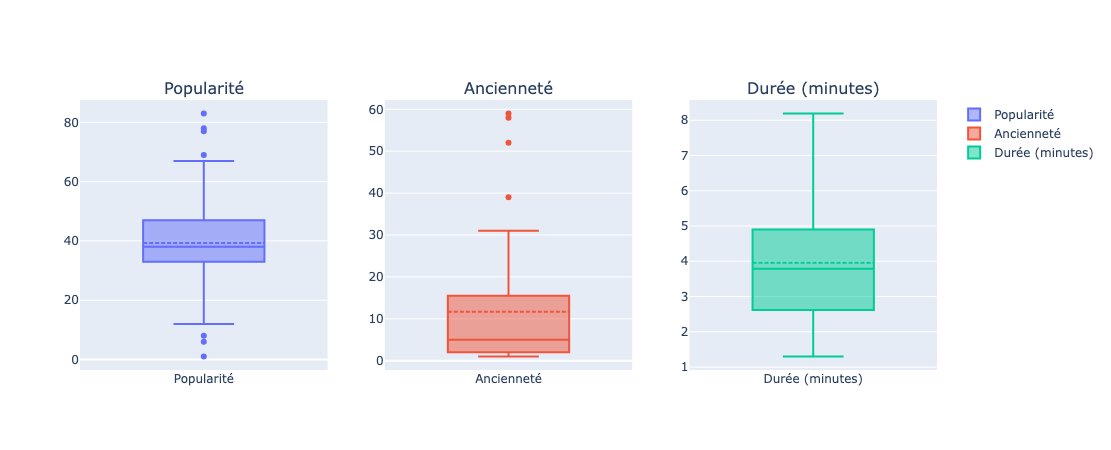

In [26]:
#Boxplot pour github
display(Image("../image/boxplot.png"))


On peut détecter quelques outliers pour la popularité et l'ancienneté

In [27]:
def detect_outliers(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1

    # bornes inf et sup
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Filtrer
    outliers_under = df[(df[column_name] < lower_bound)]
    outliers_upper = df[(df[column_name] > upper_bound)]

    return outliers_under, outliers_upper

# pour la popularité
outliers_pop_under, outliers_pop_upper = detect_outliers(df_tracks, 'popularity')
# pour l'ancienneté
outliers_anc_under, outliers_anc_upper = detect_outliers(df_tracks, 'anciennete')

In [28]:
# Afficher les titres les plus et les moins populaires
display(HTML("<b>Voici les titres les plus connus du DataFrame :</b>"))
print(f"{outliers_pop_upper[['track_name', 'artist_name', 'popularity']].sort_values(by='popularity', ascending=False)}")


display(HTML("<b>Voici les titres les moins connus du DataFrame :</b>"))
print(f"{outliers_pop_under[['track_name', 'artist_name', 'popularity']].sort_values(by='popularity', ascending=True)}")

# Afficher les titres les plus anciens
display(HTML("<b>Voici les titres les plus anciens du DataFrame :</b>"))
print(f"{outliers_anc_upper[['track_name', 'artist_name', 'anciennete']].sort_values(by='anciennete', ascending=False)}")


             track_name          artist_name  popularity
25   Livin' On A Prayer             Bon Jovi          83
31       Falling Behind               Laufey          78
18  For What It's Worth  Buffalo Springfield          77
1    N.Y. State of Mind                  Nas          69


                 track_name    artist_name  popularity
38                   Cycles     Ricky Razu           1
19  Les princes de la ville            113           6
32            it's sky time  Seb Wildblood           8


             track_name             artist_name  anciennete
18  For What It's Worth     Buffalo Springfield        59.0
2                Heroin  The Velvet Underground        58.0
10        Higher Ground           Stevie Wonder        52.0
25   Livin' On A Prayer                Bon Jovi        39.0


On récupère les titres avec des valeurs pouvant être considérées comme aberrantes pour la popularité, 
mais nous allons les laisser dans l'analyse car il n'y a pas d'erreur dans les données - bien entre 0 et 100.

Même chose pour l'ancienneté.

### Podium du Top Titres :

In [29]:
# informations sur les Top titres
images = df_tracks['album_images'][df_tracks['classement'] < 4] 
artists = df_tracks['artist_name'][df_tracks['classement'] < 4] 
tracks = df_tracks['track_name'][df_tracks['classement'] < 4] 
popularite = df_tracks['popularity'][df_tracks['classement'] < 4] 
minute = df_tracks['duration_min'][df_tracks['classement'] < 4] 

In [30]:
# Création de la figure
fig = go.Figure()

# Ajout des podiums
fig.add_shape(type="rect", x0=0, x1=1, y0=0, y1=0.2, fillcolor="lightgray", line=dict(width=0))  # Podium gauche
fig.add_shape(type="rect", x0=1, x1=2, y0=0, y1=0.3, fillcolor="gold", line=dict(width=0))      # Podium central
fig.add_shape(type="rect", x0=2, x1=3, y0=0, y1=0.2, fillcolor="lightgray", line=dict(width=0))  # Podium droit

# images
fig.add_layout_image(dict(source=images.iloc[1], x=0.5, y=0.50, xref="x", yref="y", sizex=0.5, sizey=0.5, xanchor="center", yanchor="middle"))
fig.add_layout_image(dict(source=images.iloc[0], x=1.5, y=0.60, xref="x", yref="y", sizex=0.6, sizey=0.6, xanchor="center", yanchor="middle"))
fig.add_layout_image(dict(source=images.iloc[2], x=2.5, y=0.40, xref="x", yref="y", sizex=0.5, sizey=0.5, xanchor="center", yanchor="middle"))

# nom de l'artiste et le titre
fig.add_annotation(x=0.5, y=0.1, text=f"<b>{artists.iloc[1]}<br>{tracks.iloc[1]}</b><br>Durée : {minute.iloc[1]} min<br>Popularité : {popularite.iloc[1]}", 
                   showarrow=False, font=dict(size=10), xanchor="center")
fig.add_annotation(x=1.5, y=0.1, text=f"<b>{artists.iloc[0]}<br>{tracks.iloc[0]}</b><br>Durée : {minute.iloc[0]} min<br>Popularité : {popularite.iloc[0]}", showarrow=False, font=dict(size=10), xanchor="center")
fig.add_annotation(x=2.5, y=0.1, text=f"<b>{artists.iloc[2]}<br>{tracks.iloc[2]}</b><br>Durée : {minute.iloc[2]} min<br>Popularité : {popularite.iloc[2]}", showarrow=False, font=dict(size=10), xanchor="center")


# titre
fig.add_annotation(
    x=1.5, y=0.95, text="<b>Top titres</b>", showarrow=False, font=dict(size=26), xanchor="center", yanchor="top"
)

# Mise en page
fig.update_layout(
    xaxis=dict(visible=False, range=[0, 3]),
    yaxis=dict(visible=False, range=[0, 1]),
    width=800,
    height=400,
    margin=dict(l=0, r=0, t=0, b=0),
    plot_bgcolor="white", 
    paper_bgcolor="white" 
)

# Afficher la figure
fig.show()

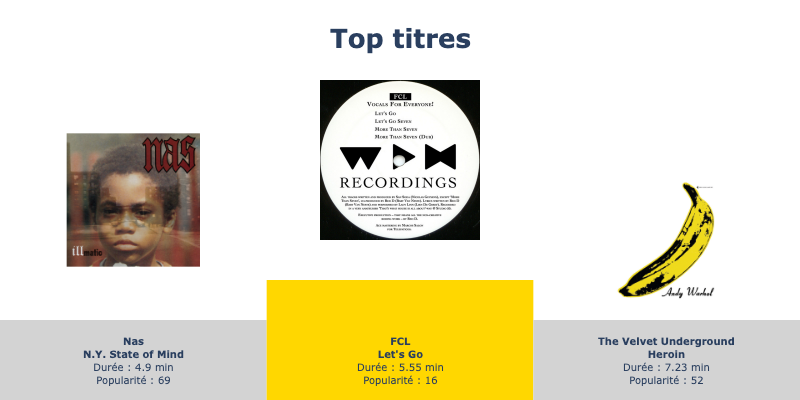

In [31]:
display(Image("../image/podium_top_titre.png"))

### Graphique intéractif pour comparer les moyennes de la popularité, de l'ancienneté et de la durée du TOP sélectionné avec tout le datamart

In [32]:
# Calculer les moyennes pour la sélection
mean_popularity = df_tracks['popularity'].mean()
mean_anciennete = df_tracks['anciennete'].mean()
mean_duration_min = df_tracks['duration_min'].mean()

In [33]:

def update_table_and_graphs(classement_max):

    filtered_tracks = df_tracks[df_tracks['classement'] <= classement_max]

    # moyennes pour la sélection
    mean_popularity_filtered = filtered_tracks['popularity'].mean()
    mean_anciennete_filtered = filtered_tracks['anciennete'].mean()
    mean_duration_min_filtered = filtered_tracks['duration_min'].mean()

    data = {
        "Catégorie": ['Popularité', 'Ancienneté', 'Durée (min)'],
        "Moyenne Totale": [round(mean_popularity, 1), round(mean_anciennete, 1), round(mean_duration_min, 1)],
        f"Moyenne TOP {classement_max}": [
            round(mean_popularity_filtered, 1),
            round(mean_anciennete_filtered, 1),
            round(mean_duration_min_filtered, 1)
        ]
    }
    df_summary = pd.DataFrame(data)

    # Transposer le DataFrame
    df_summary_transposed = df_summary.set_index("Catégorie").transpose()

    # Affichage du tableau
    table_widget = widgets.Output()
    with table_widget:
        display(df_summary_transposed)

    # Création des graphiques
    fig = make_subplots(
        rows=1, cols=3,  # Une ligne, trois colonnes
        subplot_titles=["Popularité", "Ancienneté", "Durée (min)"]
    )

    # Données pour les graphiques
    categories = ['Popularité', 'Ancienneté', 'Durée (min)']
    total_means = [round(mean_popularity, 1), round(mean_anciennete, 1), round(mean_duration_min, 1)]
    filtered_means = [round(mean_popularity_filtered, 1), round(mean_anciennete_filtered, 1), round(mean_duration_min_filtered, 1)]

    # Ajouter les graphiques
    for i, category in enumerate(categories):
        fig.add_trace(
            go.Bar(
                x=['Moyenne Totale', f'Moyenne TOP {classement_max}'],
                y=[total_means[i], filtered_means[i]],
                marker_color=['blue', 'orange']
            ),
            row=1, col=i + 1
        )

    # mise en page des graphiques
    fig.update_layout(
        height=300,  
        width=800,  
        showlegend=False,
        template="plotly_white",
        font=dict(size=8),  
        title_font=dict(size=9),  
        xaxis_title_font=dict(size=8),  
        yaxis_title_font=dict(size=8)   
    )

    # Afficher le tableau et les graphiques
    graph_widget = widgets.Output()
    with graph_widget:
        fig.show()

    # Ajouter un titre
    title_widget = widgets.HTML(
        value="<h3 style='text-align: center;'>Comparaison des moyennes du TOP sélectionné en fonction du Total</h3>"
    )

    content = widgets.VBox([
        title_widget,
        widgets.HBox([table_widget, graph_widget], layout=widgets.Layout(align_items='center'))
    ])
    display(content)

# Création d'un widget slider pour sélectionner le classement maximum
classement_slider = widgets.IntSlider(
    value=10,  # Valeur par défaut
    min=1,     
    max=50,    
    step=1,   
    description='Classement ≤',
    style={'description_width': 'initial'}
)

classement_slider.style.description_color = 'red'  # Change la couleur de la description en rouge

# Affichage interactif
widgets.interactive(update_table_and_graphs, classement_max=classement_slider)

interactive(children=(IntSlider(value=10, description='Classement ≤', max=50, min=1, style=SliderStyle(descrip…

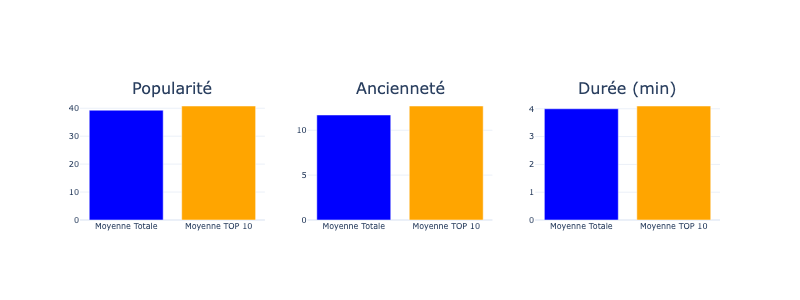

In [35]:
display(Image("../image/comparaison_moyennes.png"))

### Menu déroulant pour avoir les principales informations (Top artiste(s), top titre)

In [36]:
# Définir les réponses
artiste_pref = df_artists['artist_name'][df_artists['classement'] == 1]
titre_pref = df_tracks['track_name'][df_tracks['classement'] == 1]
artiste_top3 = df_artists['artist_name'][df_artists['classement'] < 4].tolist()

In [ ]:
# Création du menu déroulant pour choisir une question
dropdown = Dropdown(
    options=[
        "Quel est ton artiste préféré ?",
        "Quel est ton titre préféré ?",
        "Quel est ton top 3 artiste ?"
    ],
    description="Choix :",
    style={'description_width': 'initial'}
)

# Zone de sortie pour afficher la réponse
output = Output()

# Bouton "Valider"
button = Button(description="Valider", button_style="success")

# Fonction pour afficher la réponse en fonction de la sélection
def on_button_click(b):
    global rep 
    output.clear_output()
    with output:
        if dropdown.value == "Quel est ton artiste préféré ?":
            rep = f"Artiste préféré : {artiste_pref.iloc[0]}"
        elif dropdown.value == "Quel est ton titre préféré ?":
            rep = f"Titre préféré : {titre_pref.iloc[0]}"
        elif dropdown.value == "Quel est ton top 3 artiste ?":
            rep = f"Top 3 artistes : {', '.join(artiste_top3)}"
        print(rep)

button.on_click(on_button_click)  # associe la bonne fonction

# Afficher les widgets
display(VBox([Label("Sélectionnez une question :"), dropdown, button, output]))

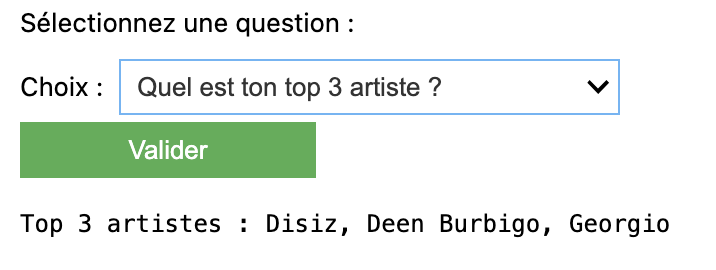

In [39]:
display(Image("../image/question_menu_deroulant.png"))


### En fonction des artistes préféré de la base de données, proposition de nouveaux artistes à découvrir

In [40]:
# Travail sur les artistes similaires
all_artists = ','.join(df_artists_info['similar_artists'].str.replace('"', '', regex=False).str.upper()).replace("{", "").replace("}", "")
artist_list = all_artists.split(',')

# Filtrer les artistes pas dans le top 50
artist_new = [artist for artist in artist_list if artist not in df_artists['artist_name'].str.upper().values]

# Compter les occurrences de chaque mot
artist_new_counts = Counter(artist_new)

In [41]:
# Afficher les 5 premiers artistes 
display(HTML("<b>Voici un exemple de 5 artistes qui pourraient vous intéresser :</b>"))

for artist, count in artist_new_counts.most_common(5):
    print(f"{artist}")

JAZZY BAZZ
AKHENATON
SHURIK'N
NÉPAL
JEANJASS


### Information sur le genre musical préféré en fonction des tracks

In [42]:
# Filtrer avec df_tracks
filtered_artists_info = df_artists_info[df_artists_info['artist_name'].isin(df_tracks['artist_name'])]

# Combiner les tags (genre musical)
all_tags = ','.join(filtered_artists_info['tags'].str.replace('"', "", regex=False).str.upper()).replace("{", "").replace("}", "")
all_tags_list = all_tags.split(',')

In [43]:
# Faire un dictionnaire de correspondances car beaucoup de genres sont similaires mais avec un nom différent
genre_dict = {
    "HIP-HOP": "Hip-Hop / Rap", "HIP HOP": "Hip-Hop / Rap", "RAP": "Hip-Hop / Rap",
    "FRENCH RAP": "Hip-Hop / Rap", "RAP FRANCAIS": "Hip-Hop / Rap", "FRENCH HIP-HOP": "Hip-Hop / Rap", "FRENCH HIP HOP": "Hip-Hop / Rap",
    "EAST COAST RAP": "Hip-Hop / Rap", "WEST COAST RAP": "Hip-Hop / Rap", "GANGSTA RAP": "Hip-Hop / Rap", "ALTERNATIVE RAP": "Hip-Hop / Rap",
    "UNDERGROUND RAP": "Hip-Hop / Rap", "UNDERGROUND HIP-HOP": "Hip-Hop / Rap", "JAZZ RAP": "Hip-Hop / Rap", "JAZZ HOP": "Hip-Hop / Rap",
    "UK HIP HOP": "Hip-Hop / Rap", "TURNTABLISM": "Hip-Hop / Rap",

    "RNB": "R&B / Soul / Funk", "NEO-SOUL": "R&B / Soul / Funk", "SOUL": "R&B / Soul / Funk", "FUNK": "R&B / Soul / Funk",
    "DAPTONE": "R&B / Soul / Funk", "GOSPEL": "R&B / Soul / Funk", "FUNK ROCK": "R&B / Soul / Funk", "MOTOWN": "R&B / Soul / Funk",

    "ELECTRONIC": "Électronique", "ELECTRO": "Électronique", "ELECTRONICA": "Électronique", "EXPERIMENTAL": "Électronique", "IDM": "Électronique",
    "INSTRUMENTAL": "Électronique", "BEATS": "Électronique", "SYNTHPOP": "Électronique", "SYNTH POP": "Électronique",
    "TRIP-HOP": "Électronique", "DOWNTEMPO": "Électronique", "CHILLOUT": "Électronique", "LOUNGE": "Électronique", "AMBIENT": "Électronique", "TRANCE": "Électronique",

    "HOUSE": "House", "DEEP HOUSE": "House", "FRENCH HOUSE": "House", "PROGRESSIVE HOUSE": "House", "AFRO-HOUSE": "House",
    "WORLD-HOUSE": "House", "NOMAD-HOUSE": "House", "UK GARAGE": "House", "MINIMAL": "House",

    "TECHNO": "Techno", "EBM": "Techno", "INDUSTRIAL": "Techno", "BREAKBEAT": "Techno", "ACID JAZZ": "Techno",

    "JAZZ": "Jazz / Blues / Swing", "JAZZ VOCAL": "Jazz / Blues / Swing", "VOCAL JAZZ": "Jazz / Blues / Swing", "SWING": "Jazz / Blues / Swing", "BLUES": "Jazz / Blues / Swing",

    "ROCK": "Rock / Indie / Pop", "CLASSIC ROCK": "Rock / Indie / Pop", "HARD ROCK": "Rock / Indie / Pop", "FOLK ROCK": "Rock / Indie / Pop",
    "PSYCHEDELIC": "Rock / Indie / Pop", "PROTO-PUNK": "Rock / Indie / Pop", "HAIR METAL": "Rock / Indie / Pop", "ALTERNATIVE ROCK": "Rock / Indie / Pop",
    "INDIE": "Rock / Indie / Pop", "INDIE ROCK": "Rock / Indie / Pop", "INDIE POP": "Rock / Indie / Pop", "SHOEGAZE": "Rock / Indie / Pop",
    "POP": "Rock / Indie / Pop", "POP-ROCK": "Rock / Indie / Pop", "FRENCH POP": "Rock / Indie / Pop", "CHANSON FRANCAISE": "Rock / Indie / Pop",

    "DEATH METAL": "Metal", "BRUTAL DEATH METAL": "Metal", "THRASH METAL": "Metal",

    "REGGAE": "Musiques du monde", "GERMAN REGGAE": "Musiques du monde", "OPM": "Musiques du monde",

    "FEMALE VOCALISTS": "Voix", "MALE VOCALISTS": "Voix",

    "SEEN LIVE": "Autres", "NOUVELLE STAR": "Autres", "AWESOME": "Autres",

}


In [44]:
tag_mapped = list(map(lambda x: genre_dict.get(x, "Non classé"), all_tags_list))

# Compter les genre qui reviennent le plus
tag_mapped_counts = Counter(tag_mapped)

# Supprimer l'entrée 'Non classé'
if 'Non classé' in tag_mapped_counts:
    del tag_mapped_counts['Non classé']


In [ ]:
# Afficher le résultat
genre_pref = tag_mapped_counts.most_common(1)

output = Output()
# afficher la réponse en cliquant sur boutton
def on_button_click(b):
    output.clear_output()
    with output:
        if b.description == "Clic ici":
            rep = f"Genre préféré : {genre_pref[0][0]}"
        print(rep)

button_genre = Button(description="Clic ici", button_style="success")
button_genre.on_click(on_button_click)

# Afficher les widgets
display(VBox([Label("Quel est ton genre de musique préféré ?"), button_genre, output]))


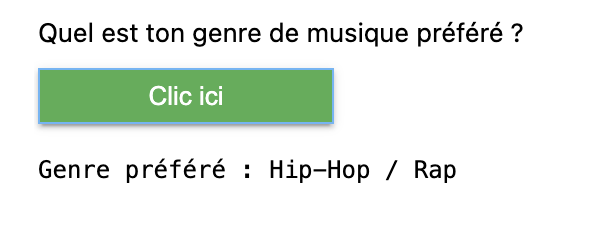

In [46]:
display(Image("../image/genre_musical_prefere.png"))

### Répartition des morceaux en fonction de la langue

In [47]:
#Travail sur les valeurs manquantes
df_parole_morceaux['parole'] = df_parole_morceaux['parole'].replace(
    '{"error":"seems like lyrics didn\'t exist on Musixmatch server."}', 'NR'
).fillna('NR')

In [48]:
print(df_parole_morceaux['parole'].head(2))

0                                                   NR
1    [00:01.35]Yeah, yeah\n[00:04.15]Ayo Black, it'...
Name: parole, dtype: object


In [49]:
# Supprimer les exp. regulières
df_parole_morceaux['parole_modif'] = df_parole_morceaux['parole'].apply(lambda x: re.sub(r'\[.*?\]', '', x))

# Fixer le seed pour des résultats reproductibles
#DetectorFactory.seed = 0

# Définir une fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Appliquer la fonction à la colonne 'parole_modif'
df_parole_morceaux['langue'] = df_parole_morceaux['parole_modif'].apply(detect_language)
df_parole_morceaux['langue'][df_parole_morceaux['parole_modif'] == 'NR'] = 'NR'  # Remplacer les valeurs 'NR' par 'NR' dans la colonne 'langue'


In [50]:
# Filtrer les données pour exclure les valeurs "NR"
langue_counts = df_parole_morceaux[df_parole_morceaux['langue'] != 'NR']['langue'].value_counts()

# Créer graphique 
fig = go.Figure(data=[go.Pie(
    labels=langue_counts.index,
    values=langue_counts.values,
    hole=0.5,  
    textinfo='percent+label',
    textfont=dict(size=14),  
    marker=dict(line=dict(color='white', width=2))  
)])

# mise en page
fig.update_layout(
    title=dict(
        text="Répartition des langues", 
        x=0.5,  
        xanchor='center',
        font=dict(size=20, family="Arial, sans-serif", color="black")  
    ),
    showlegend=True, 
    legend=dict(
        orientation="h",  
        yanchor="bottom",
        y=-0.2,  
        xanchor="center",
        x=0.5,  
        font=dict(size=12)
    ),
    margin=dict(t=50, b=50, l=50, r=50), 
    template="plotly_white"  
)

# Afficher le graphique
fig.show()

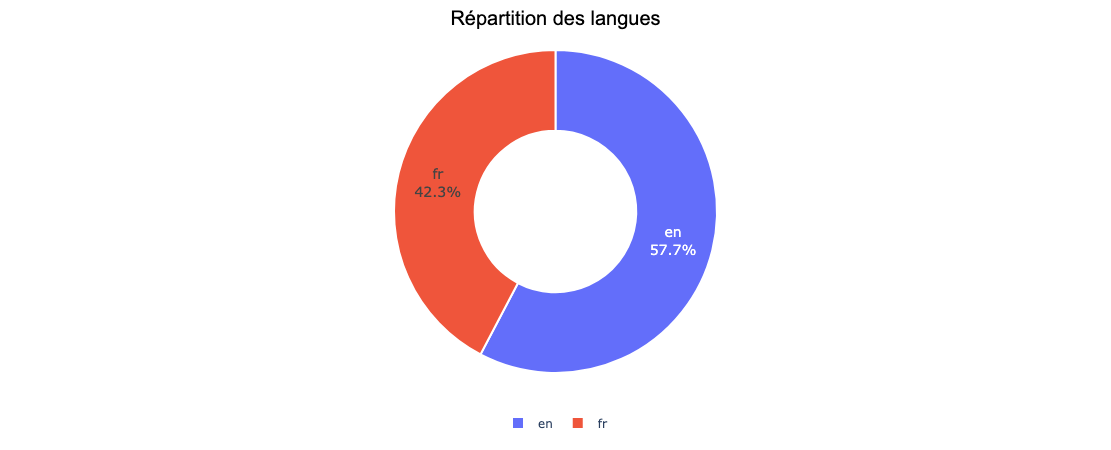

In [51]:
display(Image("../image/repartition_langues.png"))

Tous les morceaux sont classés en deux langues (anglais et français) avec une majorité d'anglais - 57.7%

## Créer automatique une playlist dans mon compte spotify en fonction du Top tracks

In [37]:
# Connexion à l'API Spotify
client_id = os.getenv("spotify_id")
client_secret = os.getenv("spotify_secret")
redirect_uri = os.getenv("spotify_uri")

In [38]:
# Authentification
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope=["playlist-modify-public", "playlist-modify-private"]))


# Crée une playlist 
user_id = sp.current_user()['id']
playlist = sp.user_playlist_create(user_id, 'Ma playlist top tracks automatique', public=True)


Using 'localhost' as a redirect URI is being deprecated. Use a loopback IP address such as 127.0.0.1 to ensure your app remains functional.


In [ ]:
# récupérer nom artiste et nom du morceau
songs = list(zip(df_tracks['artist_name'], df_tracks['track_name']))

In [ ]:
# Recherche des chansons et ajout à la playlist
track_uris = []

for artist, title in songs:
    result = sp.search(q=f"artist:{artist} track:{title}", type="track", limit=1)
    
    # Récupérer l'URI de la première piste trouvée
    if result['tracks']['items']:
        track_uri = result['tracks']['items'][0]['uri']
        track_uris.append(track_uri)
        print(f"Ajout de la chanson: {title} de {artist} à la playlist.")
    else:
        print(f"Chanson non trouvée: {title} de {artist}")

# Ajouter les morceaux à la playlist
if track_uris:
    sp.playlist_add_items(playlist['id'], track_uris)
    print("Pistes ajoutées à la playlist!")
else:
    print("Aucune piste ajoutée à la playlist.")

Ajout de la chanson: Let's Go de FCL à la playlist.
Ajout de la chanson: N.Y. State of Mind de Nas à la playlist.
Ajout de la chanson: Heroin de The Velvet Underground à la playlist.
Ajout de la chanson: CERCLE VICIEUX de Deen Burbigo à la playlist.
Ajout de la chanson: Paper de Schur à la playlist.
Ajout de la chanson: Clio 4 de ISHA à la playlist.
Ajout de la chanson: Les Alizés de Georgio à la playlist.
Ajout de la chanson: Good Vibrations de Patrice à la playlist.
Ajout de la chanson: IMMUNITÉ DIPLOMATIQUE de Deen Burbigo à la playlist.
Ajout de la chanson: Tourne la page de Darzack à la playlist.
Ajout de la chanson: Higher Ground de Stevie Wonder à la playlist.
Ajout de la chanson: GP de Booba à la playlist.
Ajout de la chanson: In Your Phase de Laurent Garnier à la playlist.
Ajout de la chanson: Smalltown Boy - Nova Version de Catastrophe à la playlist.
Ajout de la chanson: Do You Believe de Supreme Jubilees à la playlist.
Ajout de la chanson: This Feeling I Get de Doug Shorts à